In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import json

import cv2
import numpy as np
from PIL import Image
from nuscenes.utils.geometry_utils import BoxVisibility, box_in_image

sys.path.insert(0, "/cw/liir/NoCsBack/testliir/thierry/PathProjection/3d_object_detection/CenterPoint/")
sys.path.insert(0, "/cw/liir/NoCsBack/testliir/thierry/PathProjection/3d_object_detection/CenterPoint/det3d/datasets/nuscenes/")

sys.path.insert(0, "/cw/liir/NoCsBack/testliir/thierry/PathProjection/3d_object_detection/CenterPoint/nuscenes-devkit/python-sdk/")
from talk2car import Talk2Car
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.core.input.voxel_generator import VoxelGenerator
import torch

def jaccard(a, b):
    # pairwise jaccard(IoU) botween boxes a and boxes b
    lt = np.maximum(a[:, np.newaxis, :2], b[:, :2])
    rb = np.minimum(a[:, np.newaxis, 2:], b[:, 2:])
    inter = np.clip(rb - lt, 0, None)

    area_i = np.prod(inter, axis=2)
    area_a = np.prod(a[:, 2:] - a[:, :2], axis=1)
    area_b = np.prod(b[:, 2:] - b[:, :2], axis=1)

    area_u = area_a[:, np.newaxis] + area_b - area_i
    return area_i / np.clip(area_u, 1e-7, None)  # len(a) x len(b)


In [2]:
nusc = Talk2Car(version="test", dataroot="data/nuScenes", verbose=True)
predictions_file = "work_dirs/nusc_centerpoint_voxelnet_0075voxel_fix_bn_z/infos_test_10sweeps_withvelo.json"
predictions_data = json.load(open(predictions_file, "r"))

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 65.2 seconds.
Reverse indexing ...
Done reverse indexing in 19.9 seconds.


In [3]:
checkpoint = "/cw/liir/NoCsBack/testliir/thierry/PathProjection/3d_object_detection/CenterPoint/work_dirs/nusc_centerpoint_voxelnet_0075voxel_fix_bn_z/latest.pth"
config = "/cw/liir/NoCsBack/testliir/thierry/PathProjection/3d_object_detection/CenterPoint/configs/t2c/voxelnet/t2c_centerpoint_voxelnet_0075voxel_fix_bn_z.py"

In [4]:
device = "cuda:0"

cfg = Config.fromfile(config)
net = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
net.load_state_dict(torch.load(checkpoint)["state_dict"])
net = net.to(device).eval()

Use HM Bias:  -2.19


In [5]:
from det3d.datasets.pipelines import Compose

pipeline = Compose(cfg.data.test.pipeline)

no apex
No Tensorflow


In [6]:
##### Load data

###### Version 2

from det3d.datasets.nuscenes.nusc_common import *
import collections

def collate_kitti(batch_list, samples_per_gpu=1):
    example_merged = collections.defaultdict(list)
    for example in batch_list:
        if type(example) is list:
            for subexample in example:
                for k, v in subexample.items():
                    example_merged[k].append(v)
        else:
            for k, v in example.items():
                example_merged[k].append(v)
    batch_size = len(example_merged['metadata'])
    ret = {}
    # voxel_nums_list = example_merged["num_voxels"]
    # example_merged.pop("num_voxels")
    for key, elems in example_merged.items():
        if key in ["voxels", "num_points", "num_gt", "voxel_labels", "num_voxels",
                   "cyv_voxels", "cyv_num_points", "cyv_num_voxels"]:
            ret[key] = torch.tensor(np.concatenate(elems, axis=0))
        elif key in [
            "gt_boxes",
        ]:
            task_max_gts = []
            for task_id in range(len(elems[0])):
                max_gt = 0
                for k in range(batch_size):
                    max_gt = max(max_gt, len(elems[k][task_id]))
                task_max_gts.append(max_gt)
            res = []
            for idx, max_gt in enumerate(task_max_gts):
                batch_task_gt_boxes3d = np.zeros((batch_size, max_gt, 7))
                for i in range(batch_size):
                    batch_task_gt_boxes3d[i, : len(elems[i][idx]), :] = elems[i][idx]
                res.append(batch_task_gt_boxes3d)
            ret[key] = res
        elif key == "metadata":
            ret[key] = elems
        elif key == "calib":
            ret[key] = {}
            for elem in elems:
                for k1, v1 in elem.items():
                    if k1 not in ret[key]:
                        ret[key][k1] = [v1]
                    else:
                        ret[key][k1].append(v1)
            for k1, v1 in ret[key].items():
                ret[key][k1] = torch.tensor(np.stack(v1, axis=0))
        elif key in ["coordinates", "points", "cyv_coordinates"]:
            coors = []
            for i, coor in enumerate(elems):
                coor_pad = np.pad(
                    coor, ((0, 0), (1, 0)), mode="constant", constant_values=i
                )
                coors.append(coor_pad)
            ret[key] = torch.tensor(np.concatenate(coors, axis=0))
        elif key in ["anchors", "anchors_mask", "reg_targets", "reg_weights", "labels", "hm", "anno_box",
                    "ind", "mask", "cat"]:

            ret[key] = defaultdict(list)
            res = []
            for elem in elems:
                for idx, ele in enumerate(elem):
                    ret[key][str(idx)].append(torch.tensor(ele))
            for kk, vv in ret[key].items():
                res.append(torch.stack(vv))
            ret[key] = res
        elif key == 'gt_boxes_and_cls':
            ret[key] = torch.tensor(np.stack(elems, axis=0))
        else:
            ret[key] = np.stack(elems, axis=0)

    return ret

def load_data(nusc, sample, nsweeps=10, filter_zero=True):
    from nuscenes.utils.geometry_utils import transform_matrix

    ref_chan = "LIDAR_TOP"  # The radar channel from which we track back n sweeps to aggregate the point cloud.
    chan = "LIDAR_TOP"  # The reference channel of the current sample_rec that the point clouds are mapped to.

    """ Manual save info["sweeps"] """
    # Get reference pose and timestamp
    # ref_chan == "LIDAR_TOP"
    ref_sd_token = sample["data"][ref_chan]
    ref_sd_rec = nusc.get("sample_data", ref_sd_token)
    ref_cs_rec = nusc.get(
        "calibrated_sensor", ref_sd_rec["calibrated_sensor_token"]
    )
    ref_pose_rec = nusc.get("ego_pose", ref_sd_rec["ego_pose_token"])
    ref_time = 1e-6 * ref_sd_rec["timestamp"]

    ref_lidar_path, ref_boxes, _ = get_sample_data(nusc, ref_sd_token)

    ref_cam_front_token = sample["data"]["CAM_FRONT"]
    ref_cam_path, _, ref_cam_intrinsic = nusc.get_sample_data(ref_cam_front_token)

    # Homogeneous transform from ego car frame to reference frame
    ref_from_car = transform_matrix(
        ref_cs_rec["translation"], Quaternion(ref_cs_rec["rotation"]), inverse=True
    )

    # Homogeneous transformation matrix from global to _current_ ego car frame
    car_from_global = transform_matrix(
        ref_pose_rec["translation"],
        Quaternion(ref_pose_rec["rotation"]),
        inverse=True,
    )

    info = {
        "lidar_path": ref_lidar_path,
        "cam_front_path": ref_cam_path,
        "cam_intrinsic": ref_cam_intrinsic,
        "token": sample["token"],
        "sweeps": [],
        "ref_from_car": ref_from_car,
        "car_from_global": car_from_global,
        "timestamp": ref_time,
    }

    sample_data_token = sample["data"][chan]
    curr_sd_rec = nusc.get("sample_data", sample_data_token)
    sweeps = []
    while len(sweeps) < nsweeps - 1:
        if curr_sd_rec["prev"] == "":
            if len(sweeps) == 0:
                sweep = {
                    "lidar_path": ref_lidar_path,
                    "sample_data_token": curr_sd_rec["token"],
                    "transform_matrix": None,
                    "time_lag": curr_sd_rec["timestamp"] * 0,
                    # time_lag: 0,
                }
                sweeps.append(sweep)
            else:
                sweeps.append(sweeps[-1])
        else:
            curr_sd_rec = nusc.get("sample_data", curr_sd_rec["prev"])

            # Get past pose
            current_pose_rec = nusc.get("ego_pose", curr_sd_rec["ego_pose_token"])
            global_from_car = transform_matrix(
                current_pose_rec["translation"],
                Quaternion(current_pose_rec["rotation"]),
                inverse=False,
            )

            # Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
            current_cs_rec = nusc.get(
                "calibrated_sensor", curr_sd_rec["calibrated_sensor_token"]
            )
            car_from_current = transform_matrix(
                current_cs_rec["translation"],
                Quaternion(current_cs_rec["rotation"]),
                inverse=False,
            )

            tm = reduce(
                np.dot,
                [ref_from_car, car_from_global, global_from_car, car_from_current],
            )

            lidar_path = nusc.get_sample_data_path(curr_sd_rec["token"])

            time_lag = ref_time - 1e-6 * curr_sd_rec["timestamp"]

            sweep = {
                "lidar_path": lidar_path,
                "sample_data_token": curr_sd_rec["token"],
                "transform_matrix": tm,
                "global_from_car": global_from_car,
                "car_from_current": car_from_current,
                "time_lag": time_lag,
            }
            sweeps.append(sweep)

    info["sweeps"] = sweeps

    assert (
        len(info["sweeps"]) == nsweeps - 1
    ), f"sweep {curr_sd_rec['token']} only has {len(info['sweeps'])} sweeps, you should duplicate to sweep num {nsweeps-1}"
    """ read from api """

    annotations = [
        nusc.get("sample_annotation", token) for token in sample["anns"]
    ]

    mask = np.array([(anno['num_lidar_pts'] + anno['num_radar_pts'])>0 for anno in annotations], dtype=bool).reshape(-1)

    locs = np.array([b.center for b in ref_boxes]).reshape(-1, 3)
    dims = np.array([b.wlh for b in ref_boxes]).reshape(-1, 3)
    # rots = np.array([b.orientation.yaw_pitch_roll[0] for b in ref_boxes]).reshape(-1, 1)
    velocity = np.array([b.velocity for b in ref_boxes]).reshape(-1, 3)
    rots = np.array([quaternion_yaw(b.orientation) for b in ref_boxes]).reshape(
        -1, 1
    )
    names = np.array([b.name for b in ref_boxes])
    tokens = np.array([b.token for b in ref_boxes])
    gt_boxes = np.concatenate(
        [locs, dims, velocity[:, :2], -rots - np.pi / 2], axis=1
    )
    # gt_boxes = np.concatenate([locs, dims, rots], axis=1)

    assert len(annotations) == len(gt_boxes) == len(velocity)

    if not filter_zero:
        info["gt_boxes"] = gt_boxes
        info["gt_boxes_velocity"] = velocity
        info["gt_names"] = np.array([general_to_detection[name] for name in names])
        info["gt_boxes_token"] = tokens
    else:
        info["gt_boxes"] = gt_boxes[mask, :]
        info["gt_boxes_velocity"] = velocity[mask, :]
        info["gt_names"] = np.array([general_to_detection[name] for name in names])[mask]
        info["gt_boxes_token"] = tokens[mask]

    res = {
            "lidar": {
                "type": "lidar",
                "points": None,
                "nsweeps": nsweeps,
                # "ground_plane": -gp[-1] if with_gp else None,
                "annotations": None,
            },
            "metadata": {
                "image_prefix": "data/nuScenes/",
                "num_point_features": 5,
                "token": info["token"],
            },
            "calib": None,
            "cam": {},
            "mode": "val",
            "painted": False
        }

    data, _ = pipeline(res, info)
    return collate_kitti([data])
        

In [7]:
### Predictions

from nuscenes.utils.geometry_utils import BoxVisibility, box_in_image
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.png', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

"""The following code is takend from the nuscenes-devkit"""

import copy
import os.path as osp
import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict

import cv2
import numpy as np
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from matplotlib import pyplot as plt 


def view_points(points: np.ndarray, view: np.ndarray, normalize: bool) -> np.ndarray:
    """
    This is a helper class that maps 3d points to a 2d plane. It can be used to implement both perspective and
    orthographic projections. It first applies the dot product between the points and the view. By convention,
    the view should be such that the data is projected onto the first 2 axis. It then optionally applies a
    normalization along the third dimension.
    For a perspective projection the view should be a 3x3 camera matrix, and normalize=True
    For an orthographic projection with translation the view is a 3x4 matrix and normalize=False
    For an orthographic projection without translation the view is a 3x3 matrix (optionally 3x4 with last columns
     all zeros) and normalize=False
    :param points: <np.float32: 3, n> Matrix of points, where each point (x, y, z) is along each column.
    :param view: <np.float32: n, n>. Defines an arbitrary projection (n <= 4).
        The projection should be such that the corners are projected onto the first 2 axis.
    :param normalize: Whether to normalize the remaining coordinate (along the third axis).
    :return: <np.float32: 3, n>. Mapped point. If normalize=False, the third coordinate is the height.
    """

    assert view.shape[0] <= 4
    assert view.shape[1] <= 4
    assert points.shape[0] == 3

    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view

    nbr_points = points.shape[1]

    # Do operation in homogenous coordinates.
    points = np.concatenate((points, np.ones((1, nbr_points))))
    points = np.dot(viewpad, points)
    points = points[:3, :]

    if normalize:
        points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)

    return points

class Box:
    """ Simple data class representing a 3d box including, label, score and velocity. """

    def __init__(self,
                 center: List[float],
                 size: List[float],
                 orientation: Quaternion,
                 label: int = np.nan,
                 score: float = np.nan,
                 velocity: Tuple = (np.nan, np.nan, np.nan),
                 name: str = None,
                 token: str = None):
        """
        :param center: Center of box given as x, y, z.
        :param size: Size of box in width, length, height.
        :param orientation: Box orientation.
        :param label: Integer label, optional.
        :param score: Classification score, optional.
        :param velocity: Box velocity in x, y, z direction.
        :param name: Box name, optional. Can be used e.g. for denote category name.
        :param token: Unique string identifier from DB.
        """
        # print(center.shape)
        assert not np.any(np.isnan(center))
        assert not np.any(np.isnan(size))
        assert len(center) == 3
        assert len(size) == 3
        assert type(orientation) == Quaternion

        self.center = np.array(center)
        self.wlh = np.array(size)
        self.orientation = orientation
        self.label = int(label) if not np.isnan(label) else label
        self.score = float(score) if not np.isnan(score) else score
        self.velocity = np.array(velocity)
        self.name = name
        self.token = token

    def __eq__(self, other):
        center = np.allclose(self.center, other.center)
        wlh = np.allclose(self.wlh, other.wlh)
        orientation = np.allclose(self.orientation.elements, other.orientation.elements)
        label = (self.label == other.label) or (np.isnan(self.label) and np.isnan(other.label))
        score = (self.score == other.score) or (np.isnan(self.score) and np.isnan(other.score))
        vel = (np.allclose(self.velocity, other.velocity) or
               (np.all(np.isnan(self.velocity)) and np.all(np.isnan(other.velocity))))

        return center and wlh and orientation and label and score and vel

    def __repr__(self):
        repr_str = 'label: {}, score: {:.2f}, xyz: [{:.2f}, {:.2f}, {:.2f}], wlh: [{:.2f}, {:.2f}, {:.2f}], ' \
                   'rot axis: [{:.2f}, {:.2f}, {:.2f}], ang(degrees): {:.2f}, ang(rad): {:.2f}, ' \
                   'vel: {:.2f}, {:.2f}, {:.2f}, name: {}, token: {}'

        return repr_str.format(self.label, self.score, self.center[0], self.center[1], self.center[2], self.wlh[0],
                               self.wlh[1], self.wlh[2], self.orientation.axis[0], self.orientation.axis[1],
                               self.orientation.axis[2], self.orientation.degrees, self.orientation.radians,
                               self.velocity[0], self.velocity[1], self.velocity[2], self.name, self.token)

    @property
    def rotation_matrix(self) -> np.ndarray:
        """
        Return a rotation matrix.
        :return: <np.float: 3, 3>. The box's rotation matrix.
        """
        return self.orientation.rotation_matrix

    def translate(self, x: np.ndarray) -> None:
        """
        Applies a translation.
        :param x: <np.float: 3, 1>. Translation in x, y, z direction.
        """
        self.center += x

    def rotate(self, quaternion: Quaternion) -> None:
        """
        Rotates box.
        :param quaternion: Rotation to apply.
        """
        self.center = np.dot(quaternion.rotation_matrix, self.center)
        self.orientation = quaternion * self.orientation
        self.velocity = np.dot(quaternion.rotation_matrix, self.velocity)

    def corners(self, wlh_factor: float = 1.0) -> np.ndarray:
        """
        Returns the bounding box corners.
        :param wlh_factor: Multiply w, l, h by a factor to scale the box.
        :return: <np.float: 3, 8>. First four corners are the ones facing forward.
            The last four are the ones facing backwards.
        """
        w, l, h = self.wlh * wlh_factor

        # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
        x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
        y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
        z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
        corners = np.vstack((x_corners, y_corners, z_corners))

        # Rotate
        corners = np.dot(self.orientation.rotation_matrix, corners)

        # Translate
        x, y, z = self.center
        corners[0, :] = corners[0, :] + x
        corners[1, :] = corners[1, :] + y
        corners[2, :] = corners[2, :] + z

        return corners

    def bottom_corners(self) -> np.ndarray:
        """
        Returns the four bottom corners.
        :return: <np.float: 3, 4>. Bottom corners. First two face forward, last two face backwards.
        """
        return self.corners()[:, [2, 3, 7, 6]]

    def render(self,
               axis: Axes,
               view: np.ndarray = np.eye(3),
               normalize: bool = False,
               colors: Tuple = ('b', 'r', 'k'),
               linewidth: float = 2) -> None:
        """
        Renders the box in the provided Matplotlib axis.
        :param axis: Axis onto which the box should be drawn.
        :param view: <np.array: 3, 3>. Define a projection in needed (e.g. for drawing projection in an image).
        :param normalize: Whether to normalize the remaining coordinate.
        :param colors: (<Matplotlib.colors>: 3). Valid Matplotlib colors (<str> or normalized RGB tuple) for front,
            back and sides.
        :param linewidth: Width in pixel of the box sides.
        """
        corners = view_points(self.corners(), view, normalize=normalize)[:2, :]

        def draw_rect(selected_corners, color):
            prev = selected_corners[-1]
            for corner in selected_corners:
                axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
                prev = corner

        # Draw the sides
        for i in range(4):
            axis.plot([corners.T[i][0], corners.T[i + 4][0]],
                      [corners.T[i][1], corners.T[i + 4][1]],
                      color=colors[2], linewidth=linewidth)

        # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
        draw_rect(corners.T[:4], colors[0])
        draw_rect(corners.T[4:], colors[1])

        # Draw line indicating the front
        center_bottom_forward = np.mean(corners.T[2:4], axis=0)
        center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
        axis.plot([center_bottom[0], center_bottom_forward[0]],
                  [center_bottom[1], center_bottom_forward[1]],
                  color=colors[0], linewidth=linewidth)

    def render_cv2(self,
                   im: np.ndarray,
                   view: np.ndarray = np.eye(3),
                   normalize: bool = False,
                   colors: Tuple = ((0, 0, 255), (255, 0, 0), (155, 155, 155)),
                   linewidth: int = 2) -> None:
        """
        Renders box using OpenCV2.
        :param im: <np.array: width, height, 3>. Image array. Channels are in BGR order.
        :param view: <np.array: 3, 3>. Define a projection if needed (e.g. for drawing projection in an image).
        :param normalize: Whether to normalize the remaining coordinate.
        :param colors: ((R, G, B), (R, G, B), (R, G, B)). Colors for front, side & rear.
        :param linewidth: Linewidth for plot.
        """
        corners = view_points(self.corners(), view, normalize=normalize)[:2, :]
        #print(corners)
        #print()
        def draw_rect(selected_corners, color):
            prev = selected_corners[-1]
            for corner in selected_corners:
                cv2.line(im,
                         (int(prev[0]), int(prev[1])),
                         (int(corner[0]), int(corner[1])),
                         color, linewidth)
                prev = corner

        # Draw the sides
        for i in range(4):
            cv2.line(im,
                     (int(corners.T[i][0]), int(corners.T[i][1])),
                     (int(corners.T[i + 4][0]), int(corners.T[i + 4][1])),
                     colors[2][::-1], linewidth)

        # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
        draw_rect(corners.T[:4], colors[0][::-1])
        draw_rect(corners.T[4:], colors[1][::-1])

        # Draw line indicating the front
        center_bottom_forward = np.mean(corners.T[2:4], axis=0)
        center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
        cv2.line(im,
                 (int(center_bottom[0]), int(center_bottom[1])),
                 (int(center_bottom_forward[0]), int(center_bottom_forward[1])),
                 colors[0][::-1], linewidth)

    def copy(self) -> 'Box':
        """
        Create a copy of self.
        :return: A copy.
        """
        return copy.deepcopy(self)


def predict_on_local_file(nusc, sample_record):

    # load sample from file
    #self.points = self.load_cloud_from_nuscenes_file(cloud_file)
    #self.points = self.load_cloud_from_deecamp_file(cloud_file)
    sample = load_data(nusc, sample_record)
    inputs = dict(
        voxels=torch.tensor(sample["voxels"]).to(device),
        num_points=torch.tensor(sample["num_points"]).to(device),
        num_voxels=torch.tensor(sample["num_voxels"]).to(device),
        coordinates=torch.tensor(sample["coordinates"]).to(device),
        shape = torch.tensor(sample["shape"]).to(device),
    )
    #print(sample.keys())
    
    inp = {}
    for k, v in sample.items():
        if k == "coordinates":
            inp[k] = torch.tensor(
                np.pad(v, ((0, 0), (1, 0)), mode='constant', constant_values=0)).to(device)
        elif k == "shape":
            inp[k] = [v]
        elif k == "metadata":
            inp[k] = [v]
        else:
            inp[k] = torch.tensor(v).to(device)

    # predict
    torch.cuda.synchronize()
    with torch.no_grad():
        outputs = net(inp, return_loss=False)[0]

    torch.cuda.synchronize()
    
    for k, v in outputs.items():
        if k not in [
            "metadata",
        ]:
            outputs[k] = v.to("cpu")
    return outputs, sample["points"]


In [8]:
def predict_on_local_file_v2(nusc, sample_record):

    # load sample from file
    #self.points = self.load_cloud_from_nuscenes_file(cloud_file)
    #self.points = self.load_cloud_from_deecamp_file(cloud_file)
    inp = load_data(nusc, sample_record)
    
    for k,v in inp.items():
        if type(v) is torch.Tensor:
            inp[k] = v.to(device)
    
    # predict
    torch.cuda.synchronize()
    with torch.no_grad():
        outputs = net(inp, return_loss=False)[0]

    torch.cuda.synchronize()
    
    for k, v in outputs.items():
        if k not in [
            "metadata",
        ]:
            outputs[k] = v.to("cpu")
    return outputs, inp["points"]

In [136]:
import copy 
def _second_det_to_nusc_box(detection):
    box3d = detection["box3d_lidar"]
    scores = detection["scores"]
    labels = detection["label_preds"]
    box3d[:, -1] = -box3d[:, -1] - np.pi / 2
    box_list = []
    for i in range(box3d.shape[0]):
        quat = Quaternion(axis=[0, 0, 1], radians=box3d[i, -1])
        velocity = (*box3d[i, 6:8], 0.0)
        box = Box(
            list(box3d[i, :3]),
            list(box3d[i, 3:6]),
            quat,
            label=labels[i],
            score=scores[i],
            velocity=velocity,
        )
        box_list.append(box)
    return box_list

def visual(points, detections, frame_token, sensor="CAM_FRONT", eval_range=35, conf_th=0.5):
    det = copy.deepcopy(detections)
    _, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=200)
    points = remove_close(points, radius=3)
    points = view_points(points[:3, :], np.eye(4), normalize=False)

    dists = np.sqrt(np.sum(points[:2, :] ** 2, axis=0))
    colors = np.minimum(1, dists / eval_range)
    ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

    #boxes_gt = _second_det_to_nusc_box(gt_anno)
    boxes_est = _second_det_to_nusc_box(det)
    boxes_est_top = copy.deepcopy(boxes_est)
    boxes_est_frontal = copy.deepcopy(boxes_est)
    
    # Show EST boxes.
    for box in boxes_est_top:
        if box.score >= conf_th:
            box.render(ax, view=np.eye(4), colors=('r', 'r', 'r'), linewidth=1)
    
    
    # Frontal
    sample_data = nusc.get("sample_data", frame_token)
    
    #print(sample_data["token"] == frame_token)
    sample_record = nusc.get("sample", sample_data["sample_token"])
    cs_record = nusc.get("calibrated_sensor", sample_data["calibrated_sensor_token"])
    #print(sample_record["data"])
    sample_data_record = nusc.get("sample_data", sample_record["data"][sensor])
    im_path, _, cam_intr = nusc.get_sample_data(frame_token)
    
    pose_record = nusc.get("ego_pose", sample_data_record["ego_pose_token"])
    img = cv2.imread(im_path)
    yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
    
    
    ##### GT
    #boxes = nusc.get_boxes(frame_token)

    # Make list of Box objects including coord system transforms.
    #box_list = []
    #print(sample_record)
    # Top down
    
    _, top_gt_boxes, _ = nusc.get_sample_data(sample_record["data"]["LIDAR_TOP"], use_flat_vehicle_coordinates=True)
    
    lidar_sd_record = nusc.get('sample_data', sample_record["data"]["LIDAR_TOP"])
    lidar_cs_record = nusc.get("calibrated_sensor", lidar_sd_record["calibrated_sensor_token"])
    #print(lidar_cs_record, cs_record)
    #return
    #cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    #sensor_record = nusc.get('sensor', cs_record['sensor_token'])

    #print(len(top_gt_boxes))
    for box in top_gt_boxes:
        
        # Draw on top 
        box.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]).inverse)
        box.render(ax, view=np.eye(4), colors=('g', 'g', 'g'), linewidth=1)
        
        
        # Undo operations and draw on frontal
        box.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]))
        box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))
        
        #box.translate(-np.array(pose_record['translation']))

        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        #box.translate(-(np.array(lidar_cs_record['translation']) - np.array(cs_record['translation'])))
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)
        if box_in_image(box, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            print("in image")
            box.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 0, 255), (0, 0, 255), (0, 0, 255)),)

    
    _, frontal_gt_boxes, _ = nusc.get_sample_data(frame_token, use_flat_vehicle_coordinates=False)
    for box in frontal_gt_boxes:
        if box_in_image(box, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            print('drawing gt')
            box.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 255, 0), (0, 255, 0), (0, 255, 0)),)
    
    
    for obj in boxes_est_frontal:
        
        #print(obj.corners())
        if obj.score < conf_th: continue    
        obj.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]))
        obj.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))
        obj.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        obj.translate(-np.array(cs_record['translation']))
        obj.rotate(Quaternion(cs_record['rotation']).inverse)
        if box_in_image(obj, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            obj.render_cv2(img, view=cam_intr, normalize=True, colors=((255, 0, 0), (255, 0, 0), (255, 0, 0)),)
        
        #if box_in_image(obj, intrinsic=cam_intr, imsize=(1600, 900), vis_level=BoxVisibility.ANY):
        #    obj.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 0, 255), (0, 0, 255), (0, 0, 255)),)
            
    axes_limit = eval_range + 3  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    plt.axis('off')

    #plt.savefig("demo.png")
    # Top down
    plt.show()
    plt.close()
    imshow(img)
    


def remove_close(points, radius: float) -> None:
    """
    Removes point too close within a certain radius from origin.
    :param radius: Radius below which points are removed.
    """
    x_filt = np.abs(points[0, :]) < radius
    y_filt = np.abs(points[1, :]) < radius
    not_close = np.logical_not(np.logical_and(x_filt, y_filt))
    points = points[:, not_close]
    return points    

In [137]:
from det3d.datasets.nuscenes.nusc_common import (
    general_to_detection,
    cls_attr_dist,
    _lidar_nusc_box_to_global,
    eval_main
)
command = 1
sample_data = nusc.get("sample_data",nusc.commands[command].frame_token)
sample_record = nusc.get("sample", sample_data["sample_token"])
detections, points_list = predict_on_local_file_v2(nusc, sample_record)
points = points_list[:, 1:4].cpu().numpy().T

in image
in image
in image
in image
in image
drawing gt
drawing gt
drawing gt
drawing gt
drawing gt
drawing gt


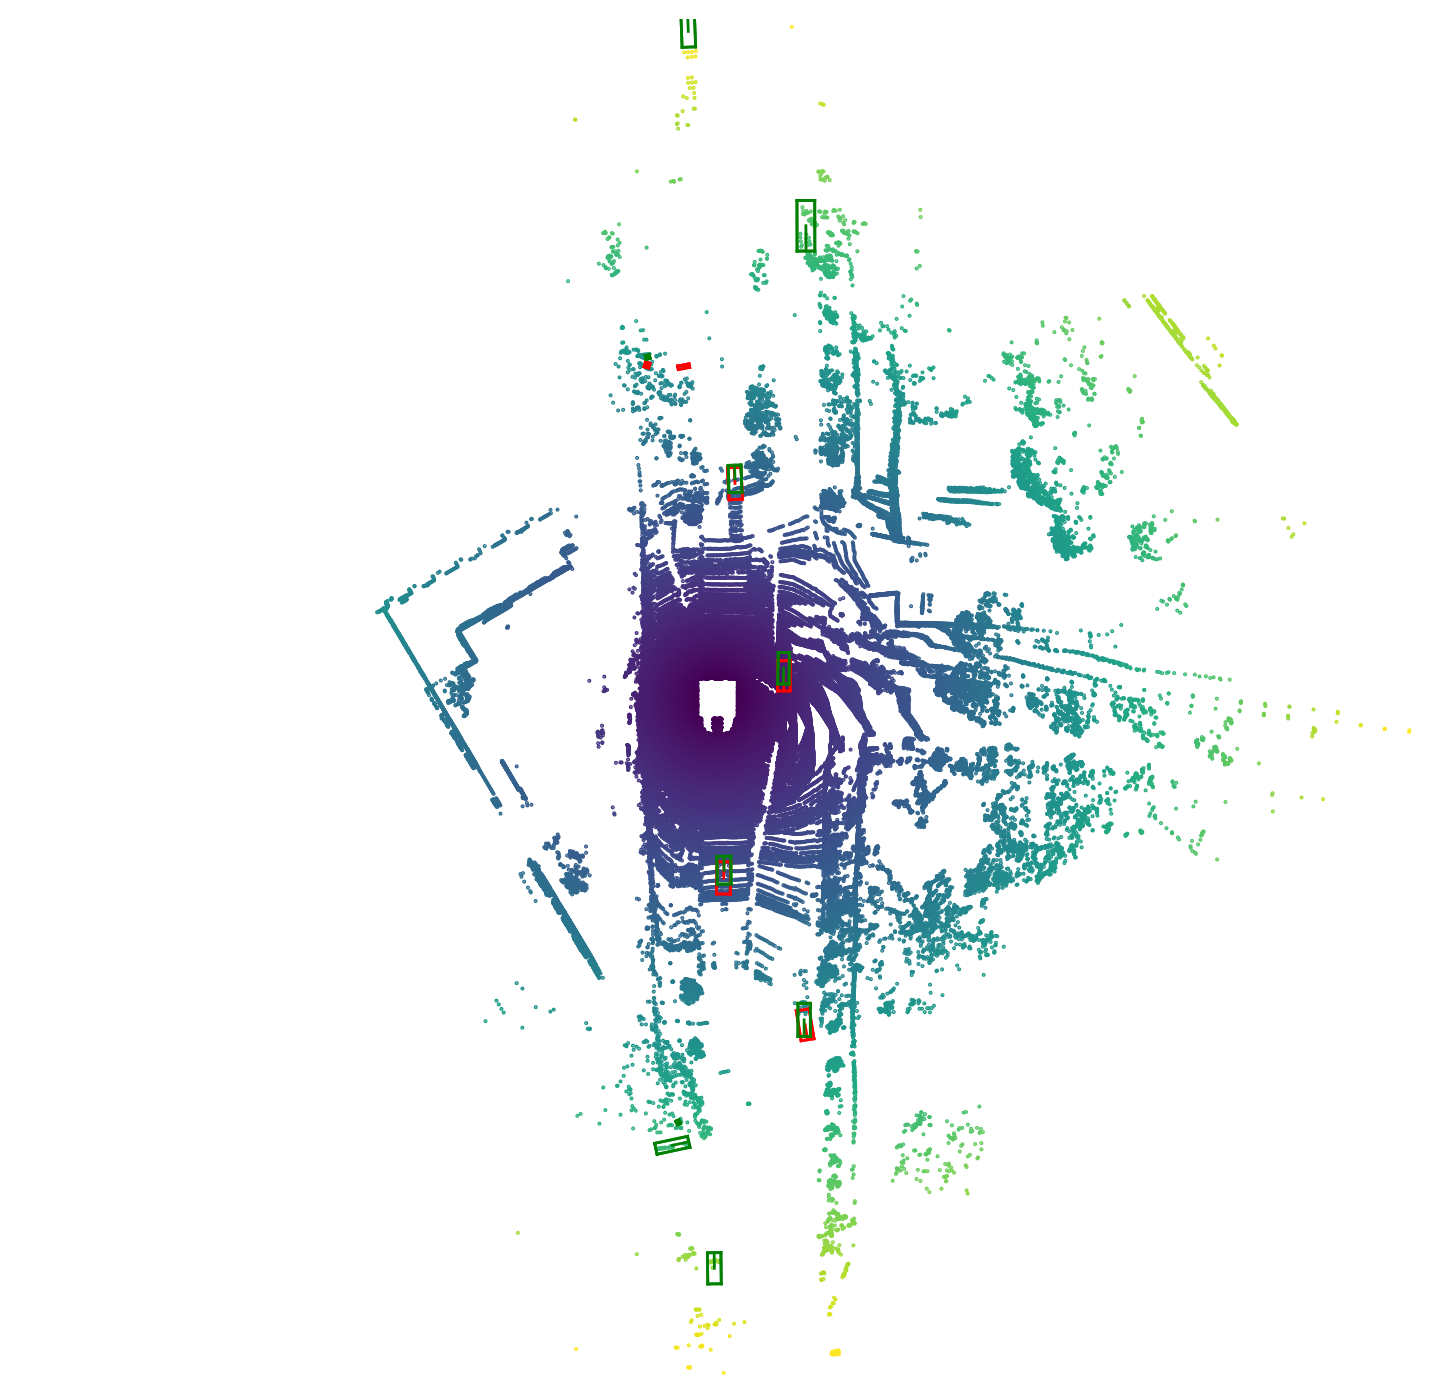

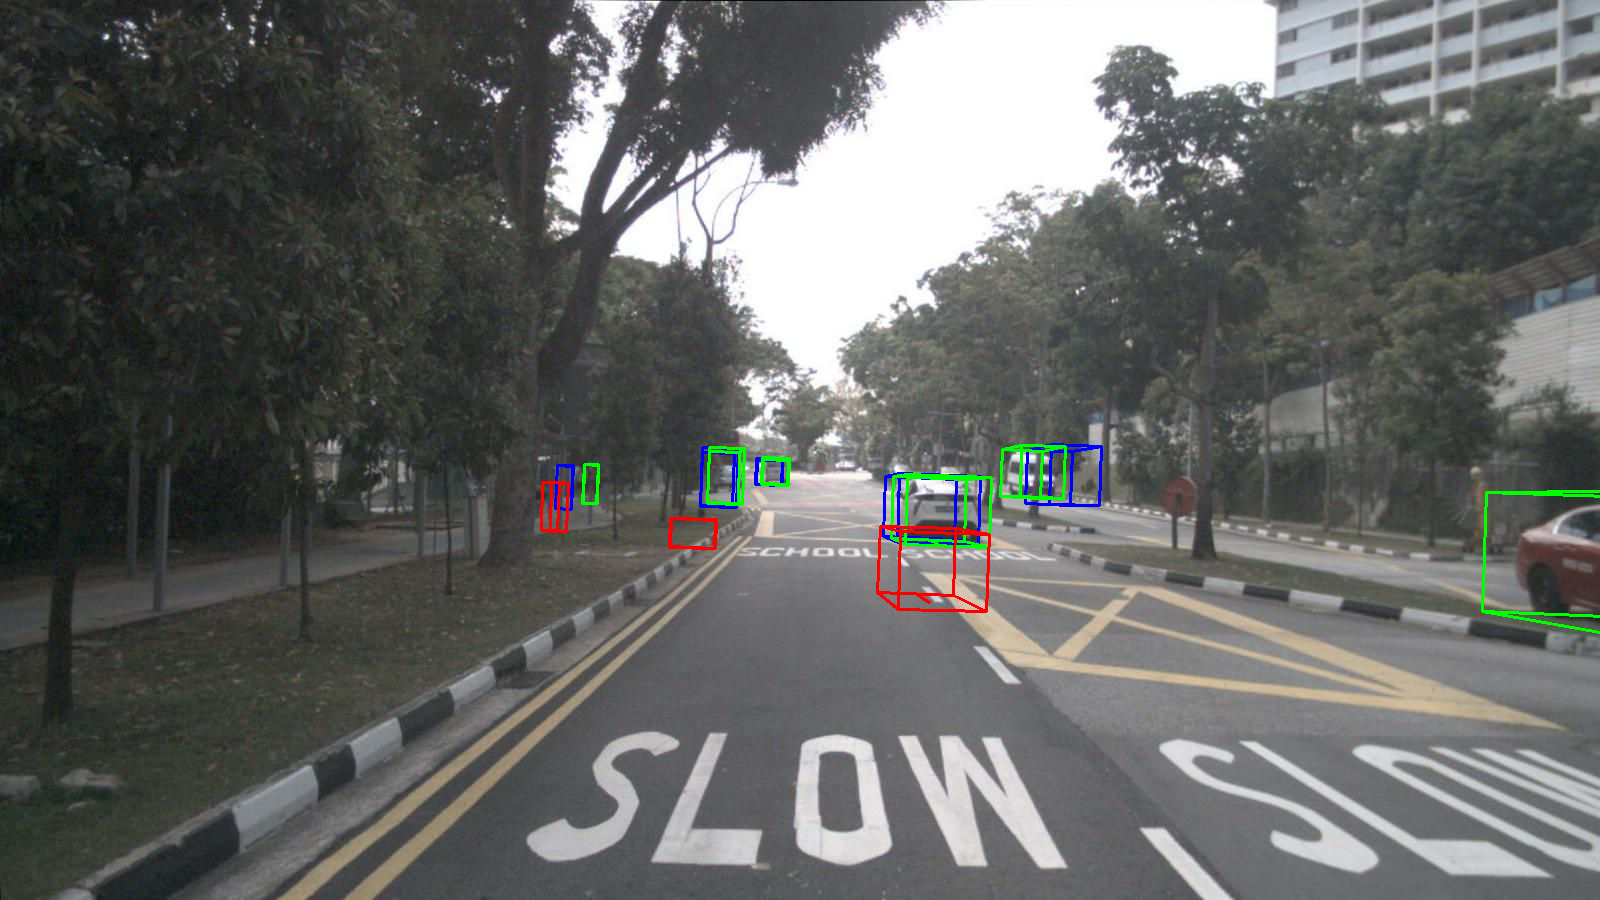

In [139]:
visual(points, detections, nusc.commands[command].frame_token, sensor="LIDAR_TOP", eval_range=100)

In [102]:
frame_token = nusc.commands[command].frame_token
# Frontal
sample_data = nusc.get("sample_data", frame_token)

#print(sample_data["token"] == frame_token)
sample_record = nusc.get("sample", sample_data["sample_token"])
lidar_sd = nusc.get("sample_data", sample_record["data"]["LIDAR_TOP"])
cs_record = nusc.get("calibrated_sensor", lidar_sd["calibrated_sensor_token"])
#print(sample_record["data"])
sample_data_record = nusc.get("sample_data", sample_record["data"]["CAM_FRONT"])
im_path, _, cam_intr = nusc.get_sample_data(frame_token)

pose_record = nusc.get("ego_pose", sample_data_record["ego_pose_token"])
img = cv2.imread(im_path)
yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]


_, boxes1, _ = nusc.get_sample_data(sample_record["data"]["LIDAR_TOP"], use_flat_vehicle_coordinates=False)
_, boxes2, _ = nusc.get_sample_data(sample_record["data"]["LIDAR_TOP"], use_flat_vehicle_coordinates=True)


In [103]:
for box in boxes2:
    # Undo operations and draw on frontal
    box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))

    #box.translate(-np.array(pose_record['translation']))

    box.rotate(Quaternion(pose_record['rotation']).inverse)

    #  Move box to sensor coord system.
    #box.translate(np.array(lidar_cs_record['translation']))
    box.translate(-np.array(cs_record['translation']))
    box.rotate(Quaternion(cs_record['rotation']).inverse)

In [104]:
for box1, box2 in zip(boxes1, boxes2):
    print(box1, box2)
    print("\n")

label: nan, score: nan, xyz: [-8.79, 109.26, 2.79], wlh: [2.91, 12.21, 4.79], rot axis: [-0.02, -0.01, -1.00], ang(degrees): -95.37, ang(rad): -1.66, vel: nan, nan, nan, name: vehicle.bus.rigid, token: 8cf40281e9d14148a5bd6aefd2eb3ef3 label: nan, score: nan, xyz: [-8.78, 109.25, 2.98], wlh: [2.91, 12.21, 4.79], rot axis: [-0.02, -0.00, -1.00], ang(degrees): -95.37, ang(rad): -1.66, vel: nan, nan, nan, name: vehicle.bus.rigid, token: 8cf40281e9d14148a5bd6aefd2eb3ef3


label: nan, score: nan, xyz: [9.79, 3.66, -1.21], wlh: [1.66, 4.75, 1.64], rot axis: [-0.01, 0.02, -1.00], ang(degrees): 90.93, ang(rad): 1.59, vel: nan, nan, nan, name: vehicle.car, token: 3a65aeb87990420fb5ffeea9b6694a66 label: nan, score: nan, xyz: [9.79, 3.66, -1.20], wlh: [1.66, 4.75, 1.64], rot axis: [-0.01, 0.02, -1.00], ang(degrees): 90.93, ang(rad): 1.59, vel: nan, nan, nan, name: vehicle.car, token: 3a65aeb87990420fb5ffeea9b6694a66


label: nan, score: nan, xyz: [-10.16, 50.84, 0.71], wlh: [0.61, 0.57, 1.72], rot

In [156]:
import copy 
def _second_det_to_nusc_box(detection):
    box3d = detection["box3d_lidar"]
    scores = detection["scores"]
    labels = detection["label_preds"]
    box3d[:, -1] = -box3d[:, -1] - np.pi / 2
    box_list = []
    for i in range(box3d.shape[0]):
        quat = Quaternion(axis=[0, 0, 1], radians=box3d[i, -1])
        velocity = (*box3d[i, 6:8], 0.0)
        box = Box(
            list(box3d[i, :3]),
            list(box3d[i, 3:6]),
            quat,
            label=labels[i],
            score=scores[i],
            velocity=velocity,
        )
        box_list.append(box)
    return box_list

def visual(points, detections, frame_token, sensor="CAM_FRONT", eval_range=35, conf_th=0.5):
    det = copy.deepcopy(detections)
    _, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=200)
    points = remove_close(points, radius=3)
    points = view_points(points[:3, :], np.eye(4), normalize=False)

    dists = np.sqrt(np.sum(points[:2, :] ** 2, axis=0))
    colors = np.minimum(1, dists / eval_range)
    ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

    #boxes_gt = _second_det_to_nusc_box(gt_anno)
    boxes_est = _second_det_to_nusc_box(det)
    boxes_est_top = copy.deepcopy(boxes_est)
    boxes_copy = copy.deepcopy(boxes_est)

    boxes_est_frontal = copy.deepcopy(boxes_est)
    
    # Show EST boxes.
    for box in boxes_est_top:
        if box.score >= conf_th:
            box.render(ax, view=np.eye(4), colors=('r', 'r', 'r'), linewidth=1)
    
    sample_data = nusc.get("sample_data", frame_token)

    #print(sample_data["token"] == frame_token)
    sample_record = nusc.get("sample", sample_data["sample_token"])
    lidar_sd = nusc.get("sample_data", sample_record["data"]["LIDAR_TOP"])
    cs_record = nusc.get("calibrated_sensor", sample_data["calibrated_sensor_token"])
    #print(sample_record["data"])
    sample_data_record = nusc.get("sample_data", sample_record["data"]["CAM_FRONT"])
    im_path, _, cam_intr = nusc.get_sample_data(frame_token)

    pose_record = nusc.get("ego_pose", sample_data_record["ego_pose_token"])
    
    for box in boxes_copy:
        if box.score < conf_th: continue    

        box.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]))
        box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))

        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        #box.translate(np.array(lidar_cs_record['translation']))
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)
        if box_in_image(box, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            print("boxes_copy")
            box.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 255, 255), (0, 255, 255), (0, 255, 255)),)

        
    _, top_gt_boxes, _ = nusc.get_sample_data(sample_record["data"]["LIDAR_TOP"], use_flat_vehicle_coordinates=True)
    
    for box in top_gt_boxes:
        
        # Draw on top 
        box.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]).inverse)
        box.render(ax, view=np.eye(4), colors=('g', 'g', 'g'), linewidth=1)
        
        box.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]))
        box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))

        #box.translate(-np.array(pose_record['translation']))

        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        #box.translate(np.array(lidar_cs_record['translation']))
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)
        if box_in_image(box, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            print("in image")
            box.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 0, 255), (0, 0, 255), (0, 0, 255)),)

    
    _, frontal_gt_boxes, _ = nusc.get_sample_data(sample_record["data"]["LIDAR_TOP"], use_flat_vehicle_coordinates=False)
    for box in frontal_gt_boxes:
        print(box)
        if box_in_image(box, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            print('drawing gt')
            box.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 255, 0), (0, 255, 0), (0, 255, 0)),)
    
    
    for obj in boxes_est_frontal:
        break
        #print(obj.corners())
        if obj.score < conf_th: continue    
        #obj.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]))
        #obj.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))
        #obj.rotate(Quaternion(pose_record['rotation']).inverse)

        #obj.translate(-np.array(cs_record['translation']))
        #obj.rotate(Quaternion(cs_record['rotation']).inverse)
        obj.rotate(Quaternion(scalar=np.cos(-np.pi / 4), vector=[0, 0, np.sin(-np.pi / 4)]))
        obj.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]))
        obj.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system.
        obj.translate(-np.array(cs_record['translation']))
        obj.rotate(Quaternion(cs_record['rotation']).inverse)
        if box_in_image(obj, cam_intr, (1600,900), vis_level=BoxVisibility.ANY):
            obj.render_cv2(img, view=cam_intr, normalize=True, colors=((255, 0, 0), (255, 0, 0), (255, 0, 0)),)
        
        #if box_in_image(obj, intrinsic=cam_intr, imsize=(1600, 900), vis_level=BoxVisibility.ANY):
        #    obj.render_cv2(img, view=cam_intr, normalize=True, colors=((0, 0, 255), (0, 0, 255), (0, 0, 255)),)
            
    axes_limit = eval_range + 3  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    plt.axis('off')

    #plt.savefig("demo.png")
    # Top down
    plt.show()
    plt.close()
    imshow(img)
    

boxes_copy
boxes_copy
boxes_copy
in image
in image
in image
in image
in image
label: nan, score: nan, xyz: [-8.79, 109.26, 2.79], wlh: [2.91, 12.21, 4.79], rot axis: [-0.02, -0.01, -1.00], ang(degrees): -95.37, ang(rad): -1.66, vel: nan, nan, nan, name: vehicle.bus.rigid, token: 8cf40281e9d14148a5bd6aefd2eb3ef3
label: nan, score: nan, xyz: [9.79, 3.66, -1.21], wlh: [1.66, 4.75, 1.64], rot axis: [-0.01, 0.02, -1.00], ang(degrees): 90.93, ang(rad): 1.59, vel: nan, nan, nan, name: vehicle.car, token: 3a65aeb87990420fb5ffeea9b6694a66
label: nan, score: nan, xyz: [-10.16, 50.84, 0.71], wlh: [0.61, 0.57, 1.72], rot axis: [-0.01, 0.02, -1.00], ang(degrees): 77.45, ang(rad): 1.35, vel: nan, nan, nan, name: human.pedestrian.child, token: 5c4d1d6a4510410e97ac92f2868afa44
label: nan, score: nan, xyz: [12.74, -49.63, -2.02], wlh: [1.84, 5.02, 1.47], rot axis: [-0.01, 0.02, -1.00], ang(degrees): 90.12, ang(rad): 1.57, vel: nan, nan, nan, name: vehicle.car, token: a72353e45cd74bff8bba76cd7ce26bb6
la

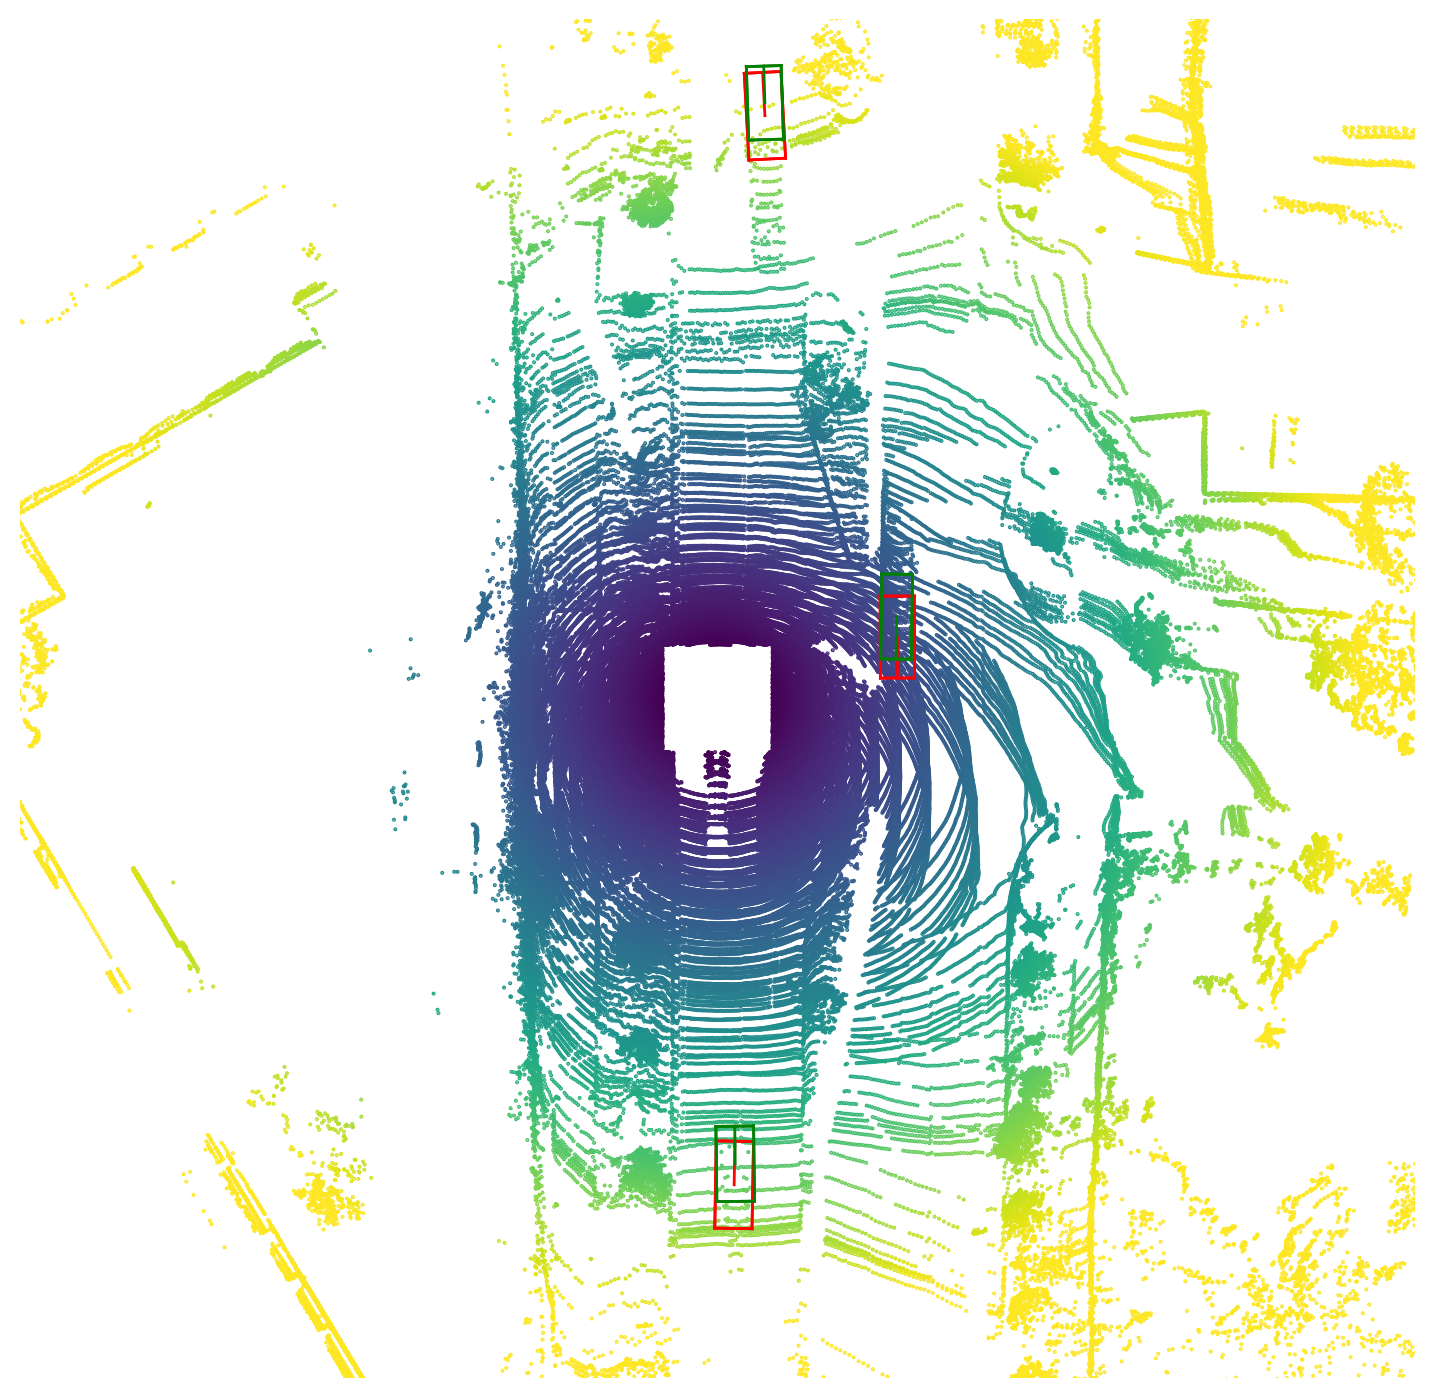

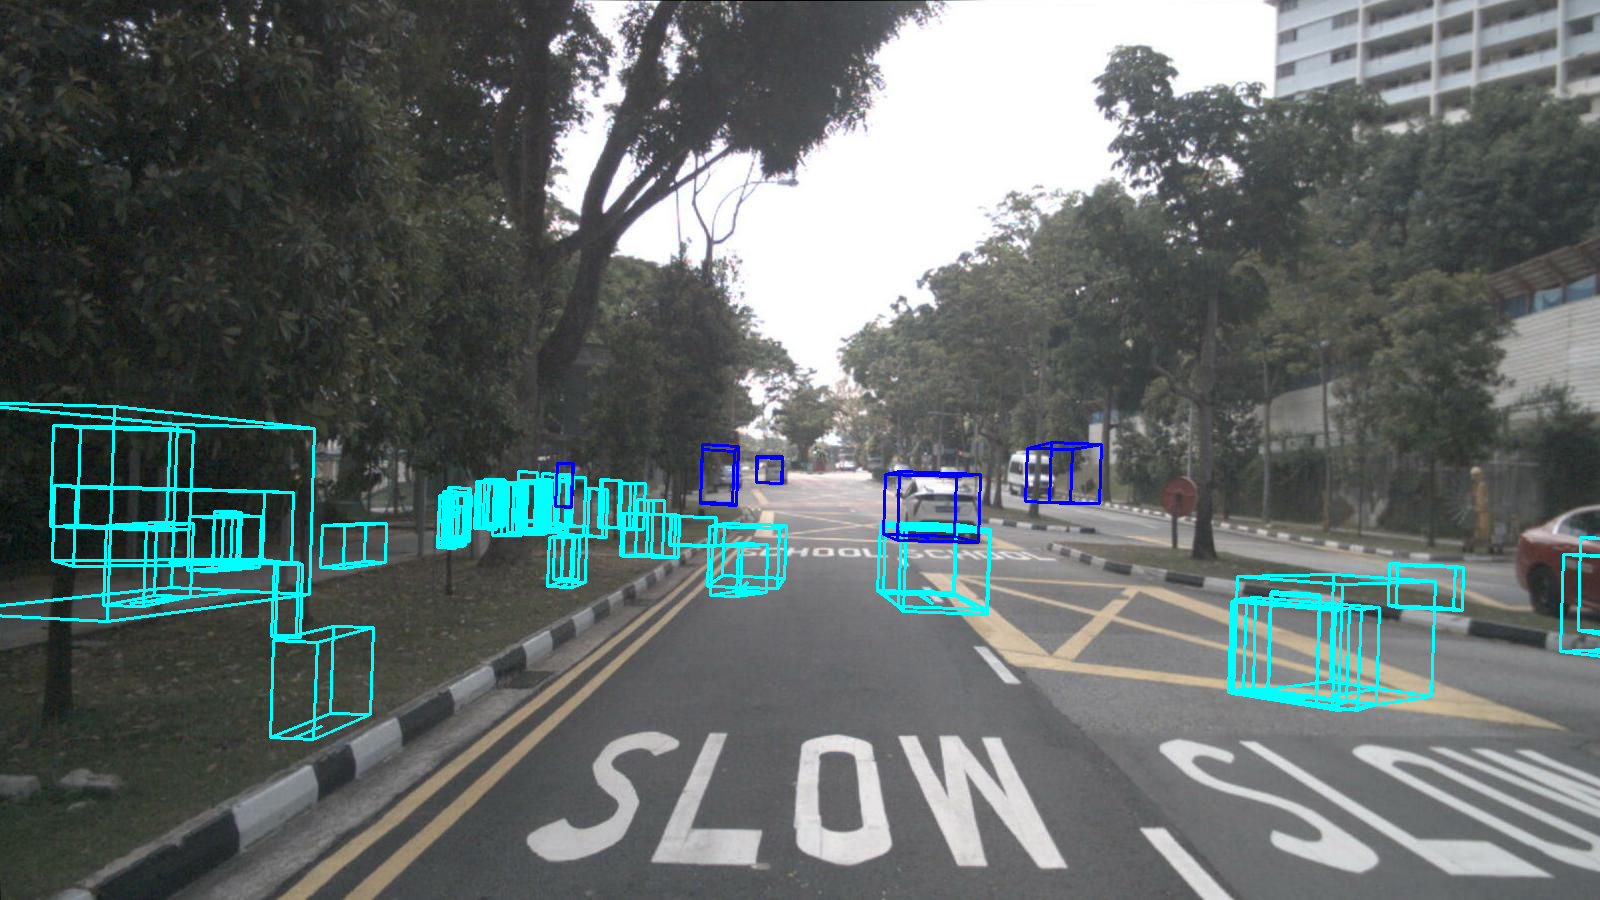

In [157]:
visual(points, detections, nusc.commands[command].frame_token, sensor="LIDAR_TOP")